<a href="https://colab.research.google.com/github/VisBudati/testrepo/blob/main/M3_F1_Implement_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: [Viswanadh Budati]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.01690221  0.00988445  0.06013552  0.09330381  0.0307541   0.04645791
  -0.0666631   0.04569132]]
test std = 
[[0.90286886 1.03319201 0.8240534  0.93173342 0.88715786 1.07384705
  0.94189994 1.01087295]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [6]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg


In [7]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [8]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [9]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization

    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g

    return w, objvals

Run gradient descent.

In [10]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5837791385916609
Objective value at t=2 is 0.5393755263598892
Objective value at t=3 is 0.5154778078275947
Objective value at t=4 is 0.5005279574318872
Objective value at t=5 is 0.49035940545951273
Objective value at t=6 is 0.48307406173185347
Objective value at t=7 is 0.4776672748367232
Objective value at t=8 is 0.47355075759395887
Objective value at t=9 is 0.4703547395267533
Objective value at t=10 is 0.4678345127614305
Objective value at t=11 is 0.46582172358462226
Objective value at t=12 is 0.4641969870609264
Objective value at t=13 is 0.4628735538322823
Objective value at t=14 is 0.46178710424810593
Objective value at t=15 is 0.46088912856177733
Objective value at t=16 is 0.46014250008340096
Objective value at t=17 is 0.4595184384725832
Objective value at t=18 is 0.4589943809878827
Objective value at t=19 is 0.45855246192418486
Objective value at t=20 is 0.45817840837944523
Objective value at t=21 is 0.457860

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [11]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar

    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg

    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix

    return obj, g

In [12]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization

    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]

        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g

        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))

    return w, objvals

Run SGD.

In [13]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5159813886480873
Objective value at epoch t=1 is 0.5064369765394356
Objective value at epoch t=2 is 0.4944664740474499
Objective value at epoch t=3 is 0.4982117953549259
Objective value at epoch t=4 is 0.48587889863430095
Objective value at epoch t=5 is 0.4886619159967324
Objective value at epoch t=6 is 0.48640472359376974
Objective value at epoch t=7 is 0.47567734014333485
Objective value at epoch t=8 is 0.4778164941151427
Objective value at epoch t=9 is 0.48175727715551975
Objective value at epoch t=10 is 0.476567407845715
Objective value at epoch t=11 is 0.4740285369224638
Objective value at epoch t=12 is 0.4697255242489994
Objective value at epoch t=13 is 0.4692687895406033
Objective value at epoch t=14 is 0.46998190721076094
Objective value at epoch t=15 is 0.4691178806102969
Objective value at epoch t=16 is 0.4661970886942811
Objective value at epoch t=17 is 0.4661309947060627
Objective value at epoch t=18 is 0.4644684642982325
Objective value at

# 4. Compare GD with SGD

Plot objective function values against epochs.

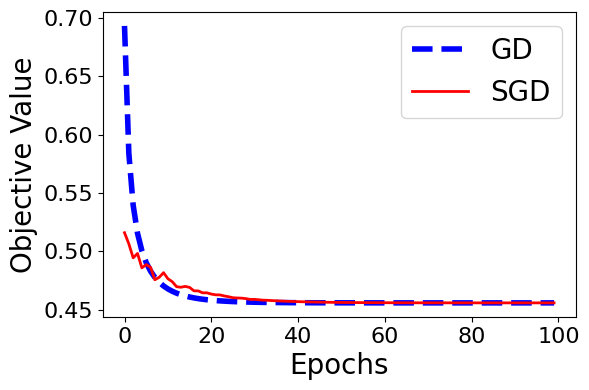

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [17]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [18]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.21875


In [19]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.25


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [20]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    yx = numpy.multiply(yi, xi)
    yxw = numpy.dot(yx, w).reshape(b, 1)
    loss = numpy.mean(numpy.log(1 + numpy.exp(-yxw)), axis=0)
    reg = lam / 2 * numpy.sum(w * w)
    obj = loss + reg

    gradient_yx = numpy.multiply(yi, xi)
    gradient_yxw = numpy.dot(gradient_yx, w)
    gradient_loss = numpy.mean((-numpy.divide(gradient_yx, 1 + (numpy.exp(gradient_yxw)))), axis=0).reshape(d, 1)
    gradient_reg = lam * w
    g = gradient_loss + gradient_reg

    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [21]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    objvals = numpy.zeros(max_epoch)
    n, d = x.shape

    if w is None:
        w = numpy.zeros((d, 1))

    for t in range(max_epoch):
        random_indices = numpy.random.permutation(n)
        random_x = x[random_indices, :]
        random_y = y[random_indices, :]
        objval = 0

        for i in range(0, n, b):
            xi = random_x[i:i+b, :]
            yi = random_y[i:i+b, :]
            obj, g_w = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            w -= stepsize * g_w
            objval += obj
        stepsize *= 0.91
        objvals[t] = objval * b / n
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objvals[t]))

    return w, objvals

## 6.3. Run MB-SGD

In [25]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.11 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5285482163313
Objective value at epoch t=1 is 0.47242043760060753
Objective value at epoch t=2 is 0.4652503004029075
Objective value at epoch t=3 is 0.46218680115077826
Objective value at epoch t=4 is 0.4628660452428668
Objective value at epoch t=5 is 0.4615307038410725
Objective value at epoch t=6 is 0.46119158904595936
Objective value at epoch t=7 is 0.4607160226610866
Objective value at epoch t=8 is 0.4601539220147924
Objective value at epoch t=9 is 0.45962306252986573
Objective value at epoch t=10 is 0.45948288712574364
Objective value at epoch t=11 is 0.45927177467059205
Objective value at epoch t=12 is 0.4586480926516187
Objective value at epoch t=13 is 0.4587203120847305
Objective value at epoch t=14 is 0.4586722766874648
Objective value at epoch t=15 is 0.458284532557019
Objective value at epoch t=16 is 0.4580523118343301
Objective value at epoch t=17 is 0.4577800858832803
Objective value at epoch t=18 is 0.45767106500433313
Objective value at 

In [26]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.4 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5741978715488947
Objective value at epoch t=1 is 0.4918491937209829
Objective value at epoch t=2 is 0.4756315338761589
Objective value at epoch t=3 is 0.46821292420650895
Objective value at epoch t=4 is 0.463515477375522
Objective value at epoch t=5 is 0.4611511710809797
Objective value at epoch t=6 is 0.4607094746790613
Objective value at epoch t=7 is 0.459404522997051
Objective value at epoch t=8 is 0.4586028039439892
Objective value at epoch t=9 is 0.4582901827275162
Objective value at epoch t=10 is 0.4588281368241501
Objective value at epoch t=11 is 0.4577514826165662
Objective value at epoch t=12 is 0.4577524189001626
Objective value at epoch t=13 is 0.45755579932022883
Objective value at epoch t=14 is 0.45750363477800143
Objective value at epoch t=15 is 0.457168571233262
Objective value at epoch t=16 is 0.45707024245889133
Objective value at epoch t=17 is 0.4570599118060336
Objective value at epoch t=18 is 0.4567004998820782
Objective value at ep

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

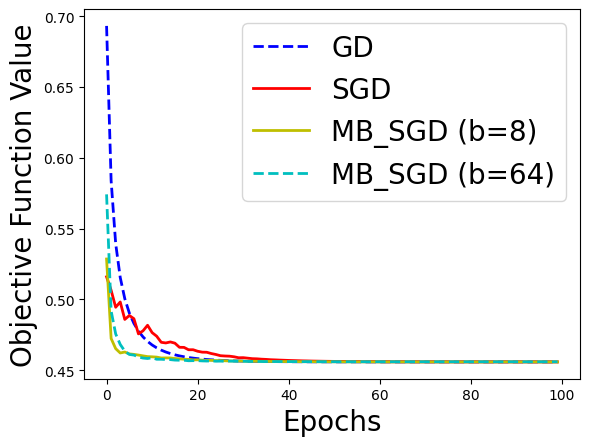

In [27]:
epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

linegd, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=2)
linesgd, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
linegd8, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-y', linewidth=2)
linegd64, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '--c', linewidth=2)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Function Value', fontsize=20)
plt.legend([linegd, linesgd, linegd8, linegd64], ['GD', 'SGD', 'MB_SGD (b=8)', 'MB_SGD (b=64)'], fontsize=20)
plt.show()